In [22]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model

In [2]:
# Read excel file in to dataframe
crimes_raw = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls', header=4)
crimes_raw.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

In [18]:
# Clean the dataframe according to specifications: population, population^2, murder, robbery
crimes = pd.DataFrame()

crimes['city'] = crimes_raw['City']
crimes['population'] = crimes_raw['Population']
crimes['population^2'] = (crimes_raw['Population'])**2
crimes['murder'] = crimes_raw['Murder and\nnonnegligent\nmanslaughter']
crimes['robbery'] = crimes_raw['Robbery']
    
crimes.head()


,city,population,population^2,murder,robbery
0,Adams Village,1861.0,3.463321e+06,0.0,0.0
1,Addison Town and Village,2577.0,6.640929e+06,0.0,0.0
2,Akron Village,2846.0,8.099716e+06,0.0,0.0
3,Albany,97956.0,9.595378e+09,8.0,227.0
4,Albion Village,6388.0,4.080654e+07,0.0,4.0


In [4]:
# Now let's format the murder and robbery columns to a boolean
crimes['murder'] = crimes.apply(lambda row: True if row['murder'] > 0 else False, axis=1)
crimes['robbery'] = crimes.apply(lambda row: True if row['robbery'] > 0 else False, axis=1)

crimes.head()

,city,population,population^2,murder,robbery
0,Adams Village,1861.0,3.463321e+06,False,False
1,Addison Town and Village,2577.0,6.640929e+06,False,False
2,Akron Village,2846.0,8.099716e+06,False,False
3,Albany,97956.0,9.595378e+09,True,True
4,Albion Village,6388.0,4.080654e+07,False,True


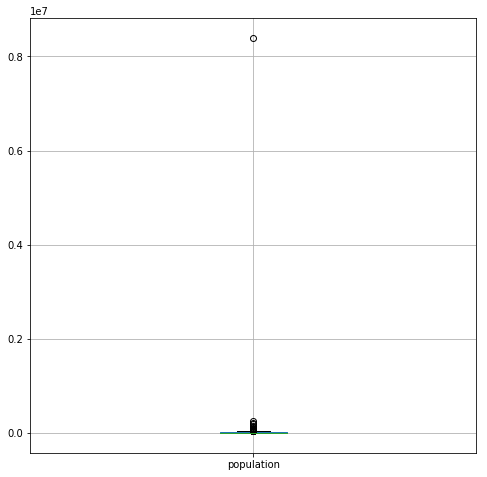

In [5]:
f, ax = plt.subplots(figsize=(8, 8))
crimes.boxplot(column='population')


#### Looks like we have a pretty significant outlier in our data. Let's find out which datapoint/s is causing this.

In [6]:
crimes['population'].describe()

count    3.480000e+02
mean     4.003763e+04
std      4.500374e+05
min      5.260000e+02
25%      3.003000e+03
50%      7.233500e+03
75%      1.842750e+04
max      8.396126e+06
Name: population, dtype: float64

#### So the population ranges from 526 to 8.3 million. But the mean is around 4000 so let's dig deaper.

In [7]:
# First let's find the row that contains the max population value
print(crimes.iloc[crimes['population'].idxmax()])

city               New York
population      8.39613e+06
population^2    7.04949e+13
murder                 True
robbery                True
Name: 216, dtype: object


#### Population drops off significantly from position 1 to 2. Let's remove the NYC data and see if the box plot becomes more readable.

In [8]:
crimes_no_nyc = crimes.drop([216])
crimes_no_nyc.describe()

,population,population^2
count,347.000000,3.470000e+02
mean,15956.685879,9.858407e+08
std,27080.218837,5.067232e+09
min,526.000000,2.766760e+05
25%,2997.000000,8.982153e+06
50%,7187.000000,5.165297e+07
75%,18160.500000,3.298042e+08
max,258789.000000,6.697175e+10


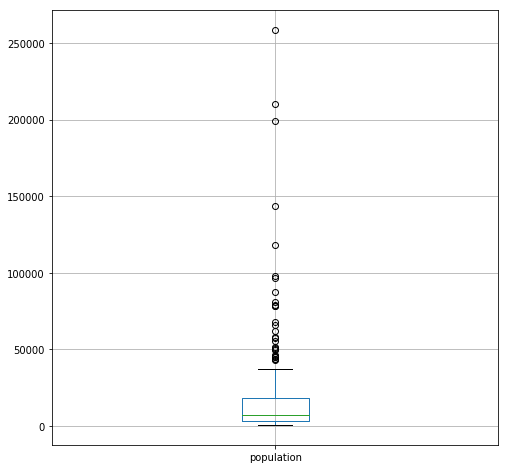

In [9]:
f, ax = plt.subplots(figsize=(8, 8))
crimes_no_nyc.boxplot(column='population')
# QUESTION: What is the difference between above method and plt.boxplot(df[crimes_no_nyc].population)

#### Yay! More outliers. Let's see what happens when we group these outliers with the NYC data.

In [10]:
# First calculate figure for upper whisker
# since whiskers are 1.5*IQR
q1 = crimes_no_nyc['population'].quantile(.25)
q3 = crimes_no_nyc['population'].quantile(.75)

upper_whisker = q3+(1.5*(q3-q1))
print(upper_whisker)

40905.75


In [11]:
# Now move cities with population greater than upper whisker to a separate dataframe
crimes_big_cities = crimes[crimes['population'] > 40906]
print(crimes_big_cities.head())
print(crimes_big_cities.shape)

                city  population  population^2  murder  robbery
3             Albany     97956.0  9.595378e+09    True     True
7       Amherst Town    118296.0  1.399394e+10    True     True
22        Binghamton     46304.0  2.144060e+09    True     True
35           Buffalo    258789.0  6.697175e+10    True     True
53  Cheektowaga Town     78361.0  6.140446e+09   False     True
(30, 5)


In [12]:
# And move cities with population smaller than upper whisker to a separate dataframe
crimes_small_cities = crimes[crimes['population'] < 40906]
print(crimes_small_cities.head())
print(crimes_small_cities.shape)

                       city  population  population^2  murder  robbery
0             Adams Village      1861.0     3463321.0   False    False
1  Addison Town and Village      2577.0     6640929.0   False    False
2             Akron Village      2846.0     8099716.0   False    False
4            Albion Village      6388.0    40806544.0   False     True
5            Alfred Village      4089.0    16719921.0   False     True
(318, 5)


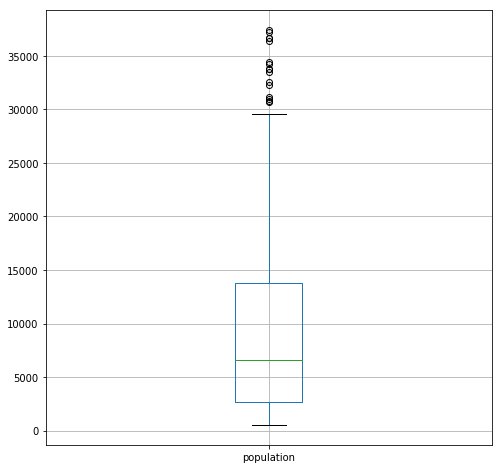

In [13]:
# Plot both sets
f, axes = plt.subplots(figsize=[8, 8])
crimes_small_cities.boxplot(column='population')

#### Looks like if we keep going down this rabbit hole, we are just going to be slicing the data into thinner and thinner pieces. It could be useful to divide the data into 3-4 different categories according to the population. But for now we will just exclude NYC since the number is so much greater that plots become meaningless and indistinguishable. And we can safely assume that a city similar to the size of NYC will definitely have at least one murder and at least one robbery in a year.

In [14]:
# Make another column to make plotting a little easier
crimes.loc[(crimes['murder'] == True), 'crime_type'] = 'murder'
crimes.loc[crimes['robbery'] == True, 'crime_type'] = 'robbery'
crimes.loc[(crimes['robbery'] == True) & (crimes['murder'] == True), 'crime_type'] = 'both'
crimes.loc[(crimes['murder'] == False) & (crimes['robbery'] == False), 'crime_type'] = 'none'

# Now copy to crimes_no_nyc
crimes_no_nyc = crimes.drop([216])
crimes_no_nyc.head(10)

,city,population,population^2,murder,robbery,crime_type
0,Adams Village,1861.0,3.463321e+06,False,False,none
1,Addison Town and Village,2577.0,6.640929e+06,False,False,none
2,Akron Village,2846.0,8.099716e+06,False,False,none
3,Albany,97956.0,9.595378e+09,True,True,both
4,Albion Village,6388.0,4.080654e+07,False,True,robbery
5,Alfred Village,4089.0,1.671992e+07,False,True,robbery
6,Allegany Village,1781.0,3.171961e+06,False,False,none
7,Amherst Town,118296.0,1.399394e+10,True,True,both
8,Amityville Village,9519.0,9.061136e+07,False,True,robbery
9,Amsterdam,18182.0,3.305851e+08,False,True,robbery


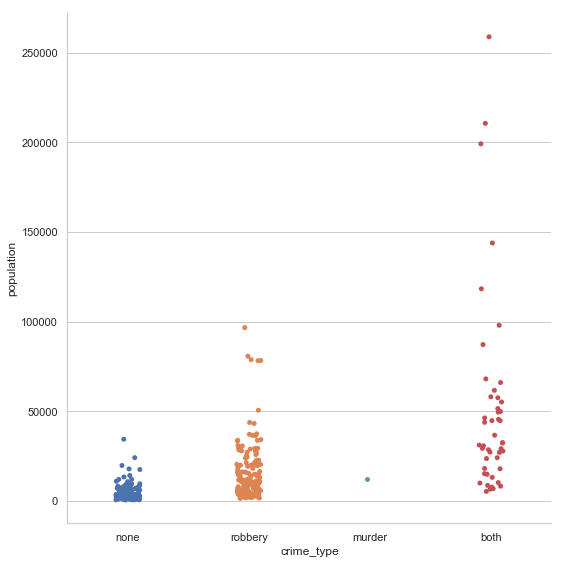

In [15]:
# Let's make a scatter plot to see the relationships between the variables
sns.set(style='whitegrid')
sns.catplot(x='crime_type', y='population', data=crimes_no_nyc, order=['none', 'robbery', 'murder', 'both'], height=8)
plt.show()

#### But since what we actually want is to predict property crimes, let's change up the data a little bit.

In [35]:
# First, let's include property crimes figures. This will be our outcome variable.
# And I want to leave the murder and robbery columns as continuous
crimes['property_crimes'] = crimes_raw['Property\ncrime']
crimes.head()

crimes_no_nyc = crimes.drop([216])

#### Let's fit our data into a linear regression model

In [38]:
crimes_no_nyc.describe()

,population,population^2,murder,robbery
count,347.000000,3.470000e+02,347.000000,347.000000
mean,15956.685879,9.858407e+08,0.605187,17.867435
std,27080.218837,5.067232e+09,3.707090,94.972492
min,526.000000,2.766760e+05,0.000000,0.000000
25%,2997.000000,8.982153e+06,0.000000,0.000000
50%,7187.000000,5.165297e+07,0.000000,1.000000
75%,18160.500000,3.298042e+08,0.000000,5.000000
max,258789.000000,6.697175e+10,47.000000,1322.000000


In [39]:
crimes_no_nyc.shape

(350, 6)

In [43]:
crimes_no_nyc[crimes_no_nyc.isnull().any(axis=1)]

,city,population,population^2,murder,robbery,property_crimes
348,1 The figures shown in this column for the off...,NaN,NaN,NaN,NaN,NaN
349,2 The figures shown in this column for the off...,NaN,NaN,NaN,NaN,NaN
350,3 The FBI does not publish arson data unless i...,NaN,NaN,NaN,NaN,NaN


In [44]:
regr = linear_model.LinearRegression()
Y = crimes_no_nyc[~crimes_no_nyc.isnull().any(axis=1)]['property_crimes'].values.reshape(-1, 1)
X = crimes_no_nyc[~crimes_no_nyc.isnull().any(axis=1)][['population', 'population^2', 'murder', 'robbery']]
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [45]:
# Coefficients
regr.coef_

array([[ 2.05519792e-02, -7.19468320e-08,  1.02643383e+02,
         5.13001360e+00]])

In [46]:
# Intercept
regr.intercept_

array([-25.0398582])

In [48]:
# R-Squared
regr.score(X, Y)

0.939283140822447

#### R-squared value shows that this model can explain about 94% of our data. and it looks like the number of robberies is the biggest indicator in predicting property crimes in this model. The intercept in our model is a negative number, meaning there is a threshold of combinations of our features after which property crime will start occurring.

### Let's test our features for the four assumptions of linear regression.  

#### First up, linearity

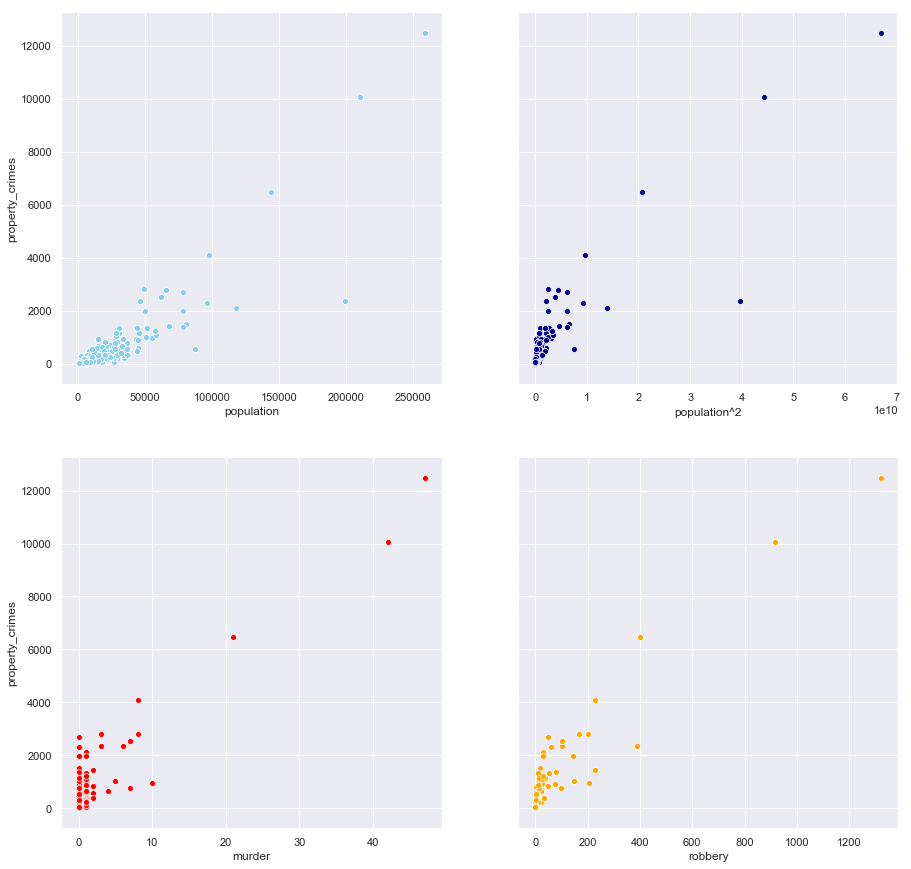

In [81]:
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharey=True)
sns.set(style='darkgrid')
sns.despine()

data = crimes_no_nyc
y = 'property_crimes'
x1 = 'population'
x2 = 'population^2'
x3 = 'murder'
x4 = 'robbery'

ax1 = axes[0, 0]
ax1 = sns.scatterplot(x=x1, y=y, data=data, ax=ax1, color='skyblue')

ax2 = axes[0, 1]
ax2 = sns.scatterplot(x=x2, y=y, data=data, ax=ax2, color='darkblue')

ax3 = axes[1, 0]
ax3 = sns.scatterplot(x=x3, y=y, data=data, ax=ax3, color='red')

ax4 = axes[1, 1]
ax4 = sns.scatterplot(x=x4, y=y, data=data, ax=ax4, color='orange')

plt.show()

#### Let's get rid of the two outliers at the top end to see if we can better visualize the plot

In [89]:
# Drop rows that have property_crimes > 10000
crimes_no_nyc = crimes_no_nyc[crimes_no_nyc['property_crimes'] < 10000]
crimes_no_nyc.shape

(345, 6)

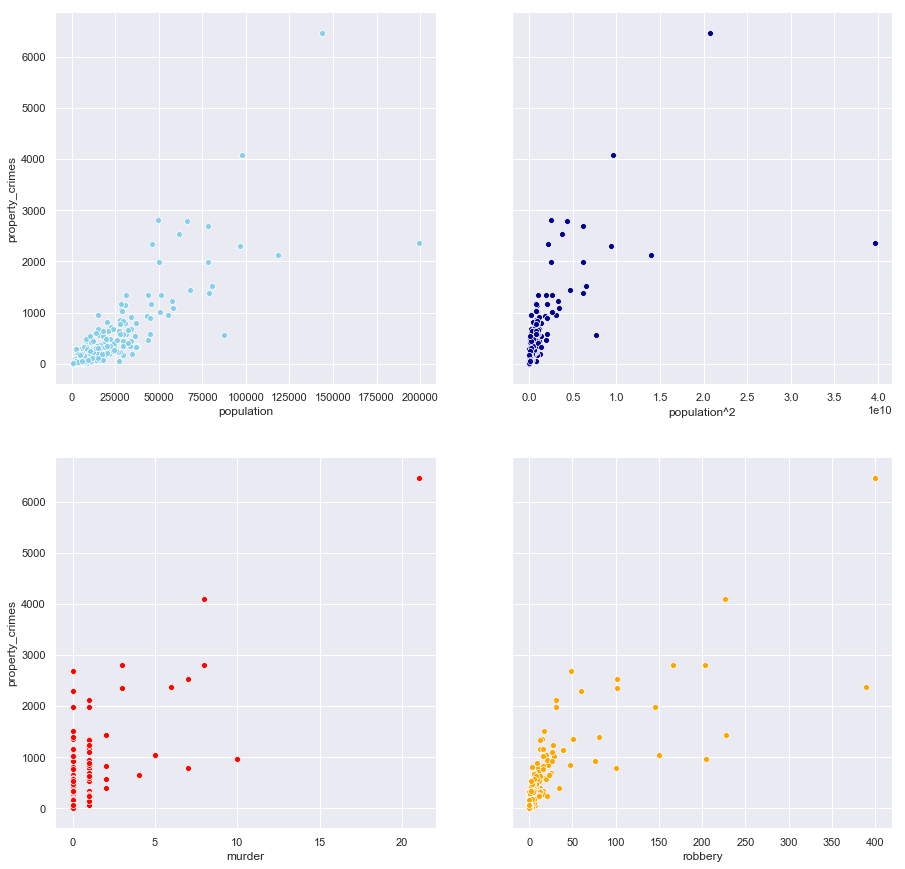

In [95]:
# Let's try plotting again
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharey=True)
sns.set(style='darkgrid')
sns.despine()

data = crimes_no_nyc
y = 'property_crimes'
x1 = 'population'
x2 = 'population^2'
x3 = 'murder'
x4 = 'robbery'

ax1 = axes[0, 0]
ax1 = sns.scatterplot(x=x1, y=y, data=data, ax=ax1, color='skyblue')

ax2 = axes[0, 1]
ax2 = sns.scatterplot(x=x2, y=y, data=data, ax=ax2, color='darkblue')

ax3 = axes[1, 0]
ax3 = sns.scatterplot(x=x3, y=y, data=data, ax=ax3, color='red')

ax4 = axes[1, 1]
ax4 = sns.scatterplot(x=x4, y=y, data=data, ax=ax4, color='orange')

plt.show()